# Modeling Crop Yield
## Python modules

In [1]:
import warnings
import time
import os

import dask
from dask.distributed import Client

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas

import pyarrow
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr

import math
import seaborn as sns

## Parameters
#### Choose a satellite.

For a description of the Landsat 8 mission, see the US Geological metadata [here.]()

For a description of the Sentinel 2 mission, see the US Geological metadata [here.]()

In [2]:
satellite = "landsat-8-c2-l2"
# satellite = "sentinel-2-l2a"

#### Choose band combination.

For a description of **Landsat** bands, see the [US Geological Survey documentation here.](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites)

For a description of **Sentinel bands**, see the [US Geological Survey documentation here.](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2#:~:text=4%20bands%20at%2010%20meter,%2Dinfrared%20(842%20nm)

According to our results, bands **(insert band selection here)** result in the best model performance for Landsat, and **(insert band selection here)** result in the best model performance for Sentinel for the task of predicting maize yields in Zambia.

In [3]:
#### Sentinel 2 bands
# bands = "2-3-4"
# bands = "2-3-4-8"
# bands = "2-3-4-5-6-7-8-11-12"

#### Landsat 8 bands
bands = "1-2-3-4-5-6-7"

#### Choose the number of points that were featurized.

Each value in the following chunk represents the amount of thousands of points that were featurized in each respective feature file. These points represent a uniform subset of the spatial grid of Zambia. Points are spaced at uniform intervals for each selection, measured in kilometers in the longitudinal direction for each set of features. The kilometer distance interval differs for each selection below; 42,000 points results in the smallest uniform distance between points, and 4,000 points results in the greatest uniform distance between points. Selecting a greater quantity of points results in a denser spatial sample, which increases computational cost and time, but increases the spatial resolution of the model. Regardless of the quantity of points selected, each point is buffered by the same distance, resulting in a 1km^2 cell around each point.

These specific options point quantities is a result of uniformly increasing the distance between points in units of kilometers prior to matching satellite images to each point. These options represent the number of points that fall within the borders of Zambia, and the numbers have been rounded to the nearest thousandth for consistency in naming files. See the [CropMOSAIKS Featurization repository](https://github.com/cropmosaiks/Featurization) for more information regarding how these distances we calculated. 

In [4]:
points = 15
# points = 20

#### Choose to keep only areas with crops (`True`) or to keep all points (`False`)

Selecting `True` applies a "cropland mask" to the spatial grid of Zambia. This retains only the regions of the country in which maize is  grown, according to the **(insert source here)**. As a result, the spatial extent of the features that are fed into the model are highly subset for the specific task at hand: modeling maize yields. According to our results, selecting `True` **(insert increases or decreases here)** model performance.

Selecting `False` results in modeling with the maximum spatial extent of the features, with more generalized features as a result.

In [5]:
# crop_mask = True
crop_mask = False

Choose a weighted average (`True`) or a simple mean (`False`) to use when collapsing features to administrative boundary level.

In [6]:
# weighted_avg = True
weighted_avg = False

#### Choose which months to use in the model.

Note that months 10, 11, and 12 get pushed to the next year because the growing season (November - May) spans the calendar year. Maize is planted in November, starts to change color with maturity in May, and is harvested in June - August. According to our results, subsetting the months to **(insert month selection here)** increases model performance.

In [7]:
# month_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
month_range = [         4, 5, 6, 7, 8, 9            ]

# month_range = [      3, 4, 5, 6, 7, 8, 9            ]
# month_range = [            5, 6, 7, 8, 9            ]
# month_range = [         4, 5, 6, 7, 8               ]
# month_range = [            5, 6, 7, 8               ]

#### Impute NA values by descending group levels (True) or `scikit learn`'s simple imputer (False)

Imputing "manually" by descending group levels imputes NA values in multiple "cascading" steps, decreasing the proportion of inoutated values with each step. First, the NA values are imputed at by both `year` and `district`, which should yield imputed values that most closely match the feature values that would be present in the data if there was no clouds obscuring the satellite images. Next, the remaining NA values that could not be imputed by both `year` and `district` are imputed by only `district`. Lastly, the remaining NA vlaues that could not be imputed by both `year` and `district` or by just `district` are imputed by `year` only. This option gives the user more control and transparency over how the imputation is executed.

Imputing using `scikit learn`'s simple imputer executes standard imputation, the details of which can be found in the `scikitlearn` documentation [here.](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

In [8]:
impute_manual = True
# impute_manual = False

In [9]:
include_2013 = True
# include_2013 = False

if include_2013 & (satellite == "landsat-8-c2-l2") & (month_range == [4, 5, 6, 7, 8, 9]):
    month_start = 4
else:
    month_start = 10

### Unchanging parmaters

The parameters in the following chunk are set for the country of Zambia for with 1000 features, regardless of the satellite selected. The start years for each satellite reflect the respective years that Landsat 8 and Sentinel 2A missions began.

The number of features is set to 1000 to serve as a staple parameter among the several other parameters varied during the model optimization process. Changing this parameter in the following code chunk will result in an error because featurizing landsat imagery for a different number of features was outside the scope of this project.

In [10]:
country_code = "ZMB"
num_features = 1000

if satellite == "landsat-8-c2-l2":
    year_start = 2013 # Landsat
else:
    year_start = 2015 # Sentinel
    
year_end = 2019
year_end_crops = 2019

data_dir = "/capstone/cropmosaiks/data"  
# data_dir = "data"  
feature_file_name = (f'{satellite}_bands-{bands}_{country_code}_{points}k-points_{num_features}-features')
weight_file_name = (f'{country_code}_crop_weights_{points}k-points')

if points == "4":
    marker_sz = 60
elif points == "15":
    marker_sz = 15
elif points == "24":
    marker_sz = 10
else:
    marker_sz = 8

## Administrative boundaries 

Administrative boundaries reflect the **(insert number of districts in dataset)** district boundaries within the country of Zambia. A district can be likened to a state within the larger U.S.A. We subset the spatial grid to district level becuase the crop yield data is at the district level of specificity. The features are originally produced at higher spatial resolution, then summarized to the district level in order to train the model with ground-truth crop data. 

<AxesSubplot:>

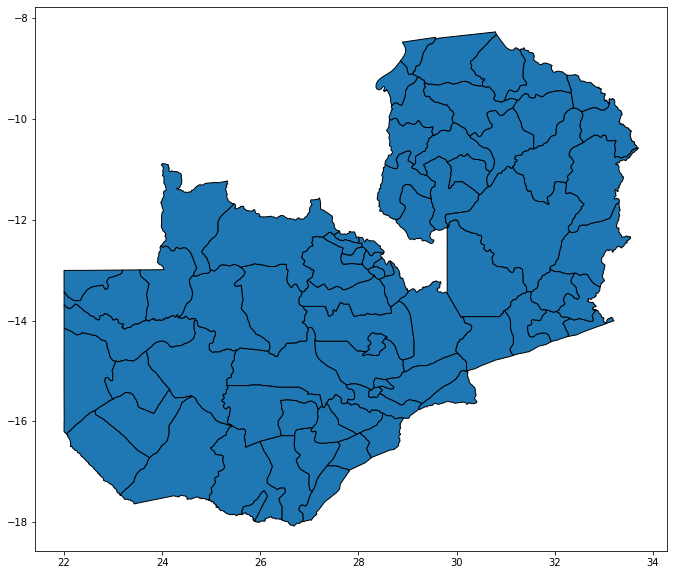

In [11]:
country_shp = geopandas.read_file(f'{data_dir}/boundaries/gadm36_{country_code}_2.shp')
country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
country_districts = country_shp.district.sort_values().unique().tolist()
country_shp = country_shp.set_index('district')
country_shp.shape
country_shp.plot(figsize = (12,10), linewidth = 1, edgecolor = 'black' )
# country_shp.plot()

## Crop yield

Zambian maize yield data reflects the predicted annual maize yield provided by farmers in the month of May, when the maize matures and changes colors prior to harvest, which allows the farmers to estimate what their yield will be in the following months. These predictions are in units of metric tons per hectare and provide valuable insight to the Zambian government as they plan for the quanitites of food to import into the country in the future. For more metadata, see the websites for the [Central Statistics Office of Zambia (CSO)](https://www.zamstats.gov.zm/) and the [Summary statistics from CSO.](https://www.zamstats.gov.zm/agriculture-environment-statistics/)

In order to standardize the names of all districts shared between the geoboundaries and the crop yield data, we correct for spelling, dashes, and apostrophes. 


In [12]:
crop_df_full = pd.read_csv(data_dir+'/crops/cfs_maize_districts_zambia_2009_2018.csv')
crop_df_full = pd.read_csv(data_dir+'/crops/cfs_maize_districts_zambia_2009_2022.csv')
crop_df_full = crop_df_full[crop_df_full.year <= year_end_crops]
crop_df_full.district = crop_df_full.district.replace(
    {"Itezhi-tezhi": 'Itezhi-Tezhi',
     "Kapiri-Mposhi": 'Kapiri Mposhi',
     "Kapiri mposhi": 'Kapiri Mposhi',
     "Shang'ombo": 'Shangombo',
     "Chienge": 'Chiengi'
    }, regex=True)
crop_districts = crop_df_full.district.sort_values().unique().tolist()
crop_df = crop_df_full[['district', 'year', 'yield_mt']]
ln = len(crop_df[crop_df.year == 2016].district)
crop_df = crop_df.set_index('district')
ln
crop_df_full
# crop_df

,year,district,area_planted,area_harvested,expected_pn,yield_mt,sales,basal_fert,top_dressing
0,2009,Chadiza,20916.369000,20856.551000,27900.844000,1.333924,6096.806200,1237.203600,1210.845500
1,2010,Chadiza,19926.268000,17760.463000,36914.285000,1.852544,12218.540000,2094.636700,2205.051500
2,2011,Chadiza,21878.699000,21293.283000,42951.039000,6.846486,24449.482000,1974.244400,2066.669200
3,2012,Chadiza,23893.803000,21453.432000,51339.688000,2.148661,23595.830000,2048.529300,2029.082200
4,2013,Chadiza,24901.465000,23475.918000,50022.227000,2.008807,23455.791000,2678.220700,2635.181200
...,...,...,...,...,...,...,...,...,...
803,2019,Lukulu,6783.252964,1227.628854,1181.949175,0.174245,180.794498,159.608375,147.435700
804,2019,Mongu,11414.274750,3027.777349,3008.514719,0.263575,492.448199,23.480284,23.480284
805,2019,Senanga,21803.050340,1078.181050,558.445386,0.025613,29.689210,NaN,NaN
806,2019,Sesheke,28105.100560,4209.680739,2913.379685,0.103660,200.518815,57.161502,45.226214


In [13]:
list(set(crop_districts) - set(country_districts))

['Mafinga', 'Ikelenge']

In [14]:
list(set(country_districts) - set(crop_districts))

[]

In [15]:
country_crop = geopandas.GeoDataFrame(crop_df.join(country_shp), crs = country_shp.crs)

## Crop land

In [16]:
weights = pd.read_feather(f"{data_dir}/weights/{weight_file_name}.feather")
# weights

<AxesSubplot:>

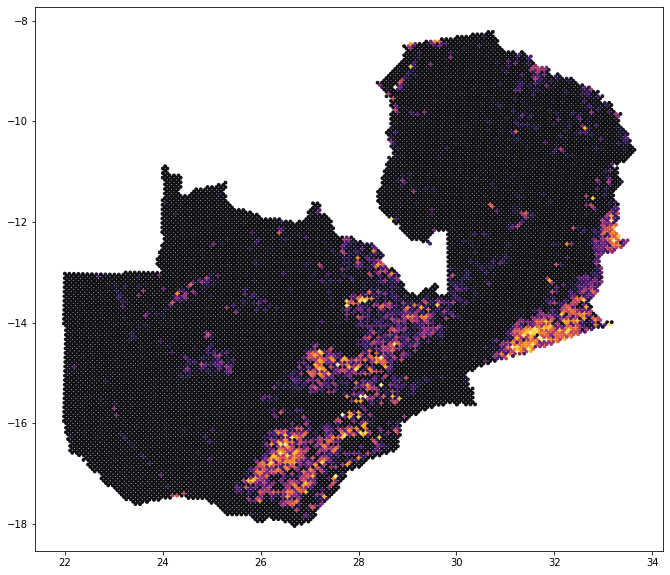

In [17]:
weights_gdf = geopandas.GeoDataFrame(
    weights, 
    geometry = geopandas.points_from_xy(x = weights.lon, y = weights.lat), 
    crs='EPSG:4326'
)
weights_gdf.plot(figsize = (12,10),
                 cmap = 'inferno',
                 markersize = marker_sz,
                 alpha = .9,
                 column = 'crop_perc')
# plt.axis('off')

In [18]:
weights.crop_perc = weights.crop_perc.fillna(0)
# #weights.crop_perc = weights.crop_perc + 0.0001

## Features

Append annual features files together into one file: `features_raw`.

In [19]:
features = geopandas.GeoDataFrame()

for yr in range(year_start, year_end + 1):
    print(f"Opening: {feature_file_name}_{yr}.feather")
    features_x = pd.read_feather(f"{data_dir}/features/{satellite}/{feature_file_name}_{yr}.feather")
    
    # concatenate the feather files together, axis = 0 specifies to stack rows (rather than adding columns)
    features = pd.concat([features, features_x], axis=0)
    
    print("feature.shape", features.shape)
    print("Appending:", yr)
    print("")

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_2013.feather
feature.shape (101946, 1004)
Appending: 2013

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_2014.feather
feature.shape (209556, 1004)
Appending: 2014

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_2015.feather
feature.shape (331388, 1004)
Appending: 2015

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_2016.feather
feature.shape (451583, 1004)
Appending: 2016

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_2017.feather
feature.shape (551236, 1004)
Appending: 2017

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_2018.feather
feature.shape (665414, 1004)
Appending: 2018

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_2019.feather
feature.shape (785094, 1004)
Appending: 2019



In [20]:
keep = np.where(
    ((features.year == year_start) & 
     (features.month >= month_start)) | 
    (features.year > year_start),
    True, False
)
features = features[keep]

In [21]:
# carry months October, November, and December over to the following year's data
# these months represent the start of the growing season for the following year's maize yield
features['year'] = np.where(
    features['month'].isin([10, 11, 12]),
    features['year'] + 1, 
    features['year'])

features = features[features['year'] <= year_end]

features.sort_values(['year', 'month'], inplace=True)

### Filter month range

In [22]:
# subset the features to only the month range selected at the top of the notebook
features = features[features.month.isin(month_range)]

### Pivot wider
Here we pivot the data from long format to wide by indexing on 'lon', 'lat', 'year', 'month' and using the unstack function. We then map column names based on the month index and the associated features so month '01' is appended to each feature for that month making 0_01, 1_01 etc. This results in a Tidy data structure, with each row representing an image, and each column representing a feature for a certain month.

In [23]:
features = features.set_index(['lon','lat', "year", 'month']).unstack()
features.columns = features.columns.map(lambda x: '{}_{}'.format(*x))

### Replace "inf" values with `NaN`

Infinity values are the result of **(insert reason here)**. We replace them with `NaN` because **(insert reason here)**.

In [24]:
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features = features.reset_index()
# features

### Attach crop weights
Attach weight to each point (% area cropped of surrounding 1 km^2).

In [25]:
features = features.join(weights.set_index(['lon', 'lat']), on = ['lon', 'lat'])
features = features.drop(["geometry"], axis = 1)
# features

### Mask croppped regions

In [26]:
# any 1 km^2 cell with a crop percentage > 0 will be retained
# the mask will not be applied if crop_mask is set to False at the top of this notebook
if crop_mask:
    features = features[features.crop_perc > 0]
else:
    pass
# features

### Make "features" a `GeoDataFrame`

The coordinate reference system is set to EPSG 4326 - WGS 84, the latitude/longitude coordinate system based on the Earth's center of mass, used by the Global Positioning System.

In [27]:
features = geopandas.GeoDataFrame(
    features, 
    geometry = geopandas.points_from_xy(x = features.lon, y = features.lat), 
    crs='EPSG:4326'
)

### Plot any single feature

In [28]:
# mn = 9
# yr = 2017
# feature = 999

# features[features.year == yr].plot(
#     column = f"{feature}_{mn}",
#     figsize = (10,10),
#     marker='H',
#     # legend = True,
#     markersize = marker_sz,
# )

### Drop 'lat' and 'lon' columns

In [29]:
# Drop the redundant independent lon and lat columns now that they are in a geometry column
features = features.drop(['lon', 'lat'], axis = 1)

### Join features to country geometry

In [30]:
features = features.sjoin(country_shp, how = 'left', predicate = 'within')
# features

In [31]:
# na = features[adm_features.isna().any(axis = 1)]
# na.plot(figsize = (10,10), markersize = 10)

### Correct column names and drop geometry

In [32]:
features = (
    features
    .dropna(subset=['index_right'])
    .rename(columns = {"index_right": "district",})
    .reset_index(drop = True)
)
points = features.copy()
points = features[['geometry']]
features = features.drop(['geometry'], axis = 1)
# features

### Impute missing values

Imputing "manually" by descending group levels imputes NA values in multiple "cascading" steps, decreasing the proportion of inoutated values with each step. First, the NA values are imputed at by both `year` and `district`, which should yield imputed values that most closely match the feature values that would be present in the data if there was no clouds obscuring the satellite images. Next, the remaining NA values that could not be imputed by both `year` and `district` are imputed by only `district`. Lastly, the remaining NA vlaues that could not be imputed by both `year` and `district` or by just `district` are imputed by `year` only. This option gives the user more control and transparency over how the imputation is executed.

Imputing using `scikit learn`'s simple imputer executes standard imputation, the details of which can be found in the `scikitlearn` documentation [here.](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

The imputation approach depends on the selection made at the top of this notebook for `impute_manual`.

In [33]:
# compute the number of cells in the features dataframe, based on the amount of rows (images), months, and feature columns
num_cells = len(features) * len(month_range) * num_features

In [34]:
class bcolors:
    BL = '\x1b[1;34m' #GREEN
    GR = '\x1b[1;36m' #GREEN
    YL = '\x1b[1;33m' #YELLOW
    RD = '\x1b[1;31m' #RED
    RESET = '\033[0m' #RESET COLOR

In [35]:
%%time
if impute_manual:
    ln_ft = len(features)
    ln_na = len(features.dropna())
    print(f'Starting total row count: {bcolors.BL}{ln_ft}{bcolors.RESET}',
          f'\nPre-Impute NaN row count: {bcolors.RD}{ln_ft - ln_na}{bcolors.RESET}',
          f'\nPre-Impute NaN row %: {bcolors.RD}{((ln_ft - ln_na) / ln_ft)*100:.02f}{bcolors.RESET}',
          f'\nPre-Impute NaN cell %: {bcolors.RD}{(features.isna().sum().sum() / num_cells)*100:.02f}{bcolors.RESET}',
          f'\n\nStep 1: Filling NaN values by month, year, and district group average')
    features = (
        features
        .fillna(features
                .groupby(['year', 'district'], as_index=False)
                .transform('mean')
               )
    )
    ln_ft = len(features)
    ln_na = len(features.dropna())
    print(f'Post step 1 NaN row count: {bcolors.YL}{ln_ft - ln_na}{bcolors.RESET}',
          f'\nPost step 1 NaN row %: {bcolors.YL}{((ln_ft - ln_na) / ln_ft)*100:.02f}{bcolors.RESET}',
          f'\nPost step 1 NaN cell %: {bcolors.YL}{(features.isna().sum().sum() / num_cells)*100:.02f}{bcolors.RESET}',
          f'\n\nStep 2: Filling NaN values by month and district group average')
    features = (
        features
        .fillna(features
                .groupby(['district'], as_index=False)
                .transform('mean')
               )
    )
    ln_ft = len(features)
    ln_na = len(features.dropna())
    print(f'Post step 2 NaN row count: {bcolors.GR}{ln_ft - ln_na}{bcolors.RESET}',
          f'\nPost step 2 NaN row %: {bcolors.GR}{((ln_ft - ln_na) / ln_ft)*100:.02f}{bcolors.RESET}',
          f'\nPost step 2 NaN cell %: {bcolors.GR}{(features.isna().sum().sum() / num_cells)*100:.02f}{bcolors.RESET}',
          f'\n\nStep 3: Drop remaining NaN values')
    features = features.dropna(axis=0)
    print(f'Ending total row count: {bcolors.BL}{len(features)}{bcolors.RESET}\n')
else:
    features = features.set_index(['year', 'district'])
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer.fit_transform(features)
    features[:] = imputer.transform(features)
    features = features.reset_index()

Starting total row count: 104956 
Pre-Impute NaN row count: 65740 
Pre-Impute NaN row %: 62.64 
Pre-Impute NaN cell %: 15.07 

Step 1: Filling NaN values by month, year, and district group average
Post step 1 NaN row count: 19302 
Post step 1 NaN row %: 18.39 
Post step 1 NaN cell %: 3.35 

Step 2: Filling NaN values by month and district group average
Post step 2 NaN row count: 0 
Post step 2 NaN row %: 0.00 
Post step 2 NaN cell %: 0.00 

Step 3: Drop remaining NaN values
Ending total row count: 104956

CPU times: user 5min 14s, sys: 34.7 s, total: 5min 49s
Wall time: 5min 48s


### Save copy of completed data 

In [36]:
features_copy = features.copy()
features_copy['geometry'] = points.geometry

### Summarise to administrative boundary level
Weighted by cropped area, or simple mean, depending on the selection at the top of this notebook for `weighted_avg`. 

In [37]:
features.columns

Index(['year', '0_4', '0_5', '0_6', '0_7', '0_8', '0_9', '1_4', '1_5', '1_6',
       ...
       '998_8', '998_9', '999_4', '999_5', '999_6', '999_7', '999_8', '999_9',
       'crop_perc', 'district'],
      dtype='object', length=6003)

In [38]:
var_cols = features.columns[1:-2].values.tolist()
features.columns[1:-2]

Index(['0_4', '0_5', '0_6', '0_7', '0_8', '0_9', '1_4', '1_5', '1_6', '1_7',
       ...
       '998_6', '998_7', '998_8', '998_9', '999_4', '999_5', '999_6', '999_7',
       '999_8', '999_9'],
      dtype='object', length=6000)

In [39]:
%%time
if weighted_avg:
    features_summary = (
        features
        .groupby(['year', 'district'], as_index=False)
        .apply(lambda x: pd.Series([sum(x[v] * x.crop_perc) / sum(x.crop_perc) for v in var_cols]))
    )
else:
    features_summary = features.groupby(['district',"year"], as_index = False).mean()
# features_summary

CPU times: user 2.07 s, sys: 1.05 s, total: 3.12 s
Wall time: 3.1 s


### Filter Summary Data to crop data range 

In [40]:
features_summary = features_summary[features_summary.year <= year_end_crops]

### Join crop data

In [41]:
crop_df_x = crop_df[crop_df.year >= min(features_summary.year)]
crop_df_x = crop_df_x[~crop_df_x.index.isin(['Mafinga', 'Ikelenge'])]
crop_df_x.reset_index(inplace=True)
# crop_df_x

In [42]:
features_summary = (
    features_summary
    .set_index(["district", "year"])
    .join(other = crop_df_x.set_index(["district", "year"]))
    .reset_index())
# features_summary

In [43]:
# max_yield = max(features_summary.yield_mt)

In [44]:
# features_summary = features_summary[features_summary.yield_mt < max_yield]

## Model

In [45]:
model_year = features_summary[features_summary.year.isin([
    2013,
    2014,
    2015,
    2016,
    2017,
    2018,
])]

### Define `x's` and `y's`

In [46]:
if weighted_avg:
    drop_cols = ['district', 'year', 'yield_mt']
else:
    drop_cols = ['district', 'year', 'yield_mt', "crop_perc"]

In [47]:
var_cols = model_year.columns[2:-2].values.tolist()

In [48]:
model_year['yield_mt'] = np.log10(model_year['yield_mt'] + 1)

/opt/python/3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
x_all = model_year[var_cols] - model_year.groupby(['district'])[var_cols].transform('mean')
y_all = model_year['yield_mt'] - model_year.groupby(['district'])['yield_mt'].transform('mean')
# y_all = np.log10(y_all + 1)
# y_all

<AxesSubplot:xlabel='yield_mt', ylabel='Count'>

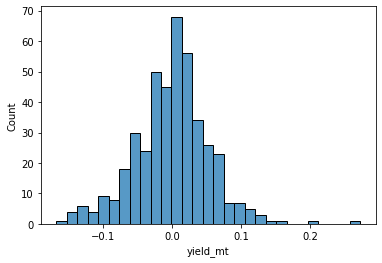

In [50]:
sns.histplot(data = y_all)

In [51]:
# x_all = model_year.drop(drop_cols, axis = 1)

# y_all = features_summary.yield_mt
# y_all = np.log10(model_year.yield_mt.to_numpy() + 1)

In [52]:
# model_year[model_year.year == 2016].iloc[: , :20]

In [53]:
# x_all

### Split into train and test sets

In [54]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=0.2, random_state=0
)

In [55]:
print("Total N: ", len(x_all), "\n", 
      "Train N: ", len(x_train), "\n",
      "Test  N: ", len(x_test), sep = "")

Total N: 432
Train N: 345
Test  N: 87


### Train model

In [56]:
# sorted(sklearn.metrics.SCORERS.keys())

In [57]:
# cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
# ridge_cv_random = RidgeCV(cv=cv, alphas=[0.001, 0.01, 1, 10])
# ridge_cv_random = RidgeCV(cv=cv, alphas=np.logspace(-8, 8, base=10, num=17))
# ridge_cv_random = RidgeCV(
#     cv=5, 
#     alphas=np.logspace(-5, 5, base=10, num=11),
#     scoring='r2',
#     scoring='max_error',
#     scoring='explained_variance'
# )
ridge_cv_random = RidgeCV(cv=5, alphas=np.logspace(-8, 8, base=10, num=17))
ridge_cv_random.fit(x_train, y_train)

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5)

In [58]:
print(f"Estimated regularization parameter {ridge_cv_random.alpha_}")

Estimated regularization parameter 10.0


### Validation set $R^2$ performance

In [59]:
print(f"Validation R2 performance {ridge_cv_random.best_score_:0.2f}")

Validation R2 performance 0.06


In [60]:
# from sklearn.model_selection import cross_val_predict
# predicted = cross_val_predict(RidgeCV(cv=5, alphas=np.logspace(-8, 8, base=10, num=17)), x_train, y_train)

In [61]:
# fig, ax = plt.subplots()
# ax.scatter(y_train, predicted, edgecolors=(0, 0, 0))
# ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "k--", lw=4)
# ax.set_xlabel("Measured")
# ax.set_ylabel("Predicted")
# plt.show()

### Train set

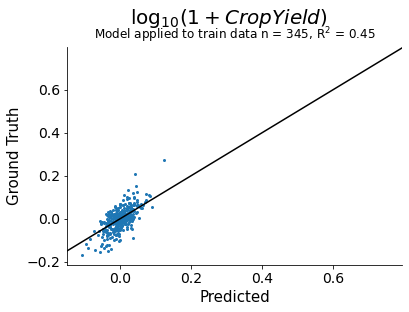

In [62]:
# y_pred = np.maximum(ridge_cv_random.predict(x_train), 0)
y_pred = ridge_cv_random.predict(x_train)
r2_train = r2_score(y_train, y_pred)
fig, ax = plt.subplots()
ax.axline([0, 0], [.75, .75], c = "k")
# fig, ax = plt.figure()
plt.scatter(y_pred, y_train, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title((f"Model applied to train data n = {len(x_train)}, R$^2$ = {(r2_score(y_train, y_pred)):0.2f}"),
          fontsize=12, y=1.01)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# m, b = np.polyfit(y_pred, y_train, 1)
# plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_train_data.jpg', dpi=300)
plt.show()
plt.close()

In [63]:
print(f"Training R^2 = {r2_train:0.2f}\nPearsons r = {pearsonr(y_pred, y_train)[0]:0.2f}") 

Training R^2 = 0.45
Pearsons r = 0.69


In [64]:
pearsonr(y_pred, y_train)[0]  ** 2

0.4696860961080634

In [65]:
ridge_cv_random.score(x_train, y_train)

0.45116924996623486

### Test set

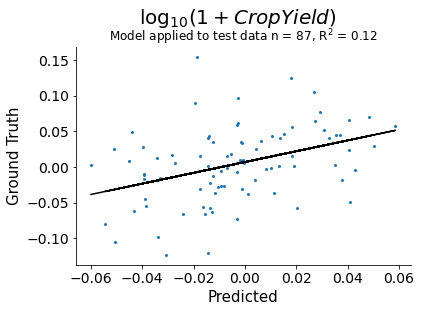

In [66]:
# y_pred = np.maximum(ridge_cv_random.predict(x_test), 0)
y_pred = ridge_cv_random.predict(x_test)
r2_test = r2_score(y_test, y_pred)
plt.figure()
plt.scatter(y_pred, y_test, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title(f"Model applied to test data n = {len(x_test)}, R$^2$ = {(r2_score(y_test, y_pred)):0.2f}",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_test_data.jpg', dpi=300)
plt.show()
plt.close()

In [67]:
print(f"Testing set R^2 = {r2_test:0.2f}")
print(f"Testing set pearsons R = {pearsonr(y_pred, y_test)[0]:0.2f}")

Testing set R^2 = 0.12
Testing set pearsons R = 0.40


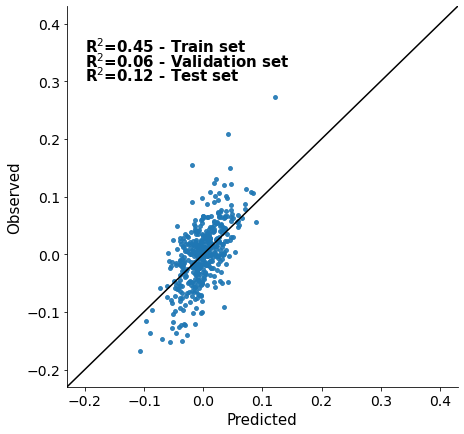

In [68]:
# y_pred = np.maximum(ridge_cv_random.predict(x_all), 0)
y_pred = ridge_cv_random.predict(x_all)

fig, ax = plt.subplots(figsize=(7, 7))
ax.axline([-0.2, -0.2], [.4, .4], c = "k")
plt.scatter(y_pred, y_all, alpha=.9, s=15)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Observed", fontsize=15)
plt.text(
    -.2, .35, fontsize=15, fontweight="bold",
    s=f"R$^2$={r2_train:0.2f} - Train set",
)
plt.text(
    -.2, .325, fontsize=15, fontweight="bold",
    s=f"R$^2$={ridge_cv_random.best_score_:0.2f} - Validation set",
)
plt.text(
    -.2, .3, fontsize=15, fontweight="bold",
    s=f"R$^2$={r2_test:0.2f} - Test set",
)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

plt.savefig(f'images/{feature_file_name}_all_data.jpg', dpi=300)
plt.show()
plt.close()